In [169]:
%load_ext autoreload
%autoreload 2


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import os
import time

from scipy.stats import t

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from IPython.display import clear_output

# Import module for data visualization
from plotnine import *
import plotnine

import pickle

%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Statistical comparison of models using grid search

This example illustrates how to statistically compare the performance of models
trained and evaluated using :class:`~sklearn.model_selection.GridSearchCV`.


# 1) Get the best performances for each model for each algorithm

In [2]:
df_best = utils.read_csv(csv_file='exec_results/best_results.csv')
display(df_best[[
    'Algorithm',
    'Scenario',
    'Features',
    'Model',
    'balanced_accuracy',
    'sensitivity',
    'specificity',
    'Model_Class',
    'Hyperparams',
    'Estimator_Class',
    'Estimator_Hyperparams',
]])

df_best.Algorithm.unique()

,Algorithm,Scenario,Features,Model,balanced_accuracy,sensitivity,specificity,Model_Class,Hyperparams,Estimator_Class,Estimator_Hyperparams
0,Decision Tree,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.81,BalancedBaggingClassifier,"{'estimator':DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42),'n_estimators':7,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}",DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'gini','max_depth':4,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}"
1,Neural Networks,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.80,BalancedBaggingClassifier,"{'estimator':MLPClassifier(activation='tanh',alpha=0.1,hidden_layer_sizes=30,learning_rate='adaptive',learning_rate_init=0.7,max_iter=2000,random_state=42),'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}",MLPClassifier,"{'activation':'tanh','alpha':0.1,'batch_size':'auto','beta_1':0.9,'beta_2':0.999,'early_stopping':False,'epsilon':1e-08,'hidden_layer_sizes':30,'learning_rate':'adaptive','learning_rate_init':0.7,'max_fun':15000,'max_iter':2000,'momentum':0.9,'n_iter_no_change':10,'nesterovs_momentum':True,'power_t':0.5,'random_state':42,'shuffle':True,'solver':'adam','tol':0.0001,'validation_fraction':0.1,'verbose':False,'warm_start':False}"
2,Random Forest,Ensemble-Imbalance,All Features,Balanced Random Forest,0.87,0.96,0.79,BalancedRandomForestClassifier,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}",RandomForest,NaN
3,SVM,Ensemble-Imbalance,All Features,Balanced Bagging,0.87,0.94,0.81,BalancedBaggingClassifier,"{'estimator':SVC(C=3,class_weight='balanced',gamma='auto',probability=True,random_state=42),'n_estimators':51,'random_state':42,'replacement':False,'sampling_strategy':'auto','warm_start':True}",SVC,"{'C':3,'break_ties':False,'cache_size':200,'class_weight':'balanced','coef0':0.0,'decision_function_shape':'ovr','degree':3,'gamma':'auto','kernel':'rbf','max_iter':-1,'probability':True,'random_state':42,'shrinking':True,'tol':0.001,'verbose':False}"
4,SVM,Single-Model,All Features,SVM,0.87,0.94,0.80,SVC,"{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}",NaN,NaN
5,Random Forest,Single-Model,All Features,Random Forest,0.87,0.89,0.86,RandomForestClassifier,"{'class_weight':'balanced','criterion':'gini','max_depth':5,'n_estimators':51,'random_state':42}",NaN,NaN
6,Neural Networks,Single-Model,All Features,Neural Networks,0.87,0.87,0.87,MLPClassifier,"{'activation':'tanh','alpha':0.3,'hidden_layer_sizes':(23,23,23),'learning_rate':'constant','learning_rate_init':0.7,'max_iter':2000,'random_state':42,'solver':'sgd'}",NaN,NaN
7,k-NN,Ensemble-Imbalance,All Features,Balanced Bagging,0.85,0.85,0.85,BalancedBaggingClassifier,"{'estimator':KNeighborsClassifier(metric='euclidean',weights='distance'),'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}",KNeighborsClassifier,"{'algorithm':'auto','leaf_size':30,'metric':'euclidean','metric_params':None,'n_jobs':None,'n_neighbors':5,'p':2,'weights':'distance'}"
8,Naïve Bayes,Ensemble-Imbalance,All Features,Balanced Bagging,0.84,0.85,0.83,BalancedBaggingClassifier,"{'estimator':GaussianNB(),'n_estimators':31,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':False}",GaussianNB,"{'priors':None,'var_smoothing':1e-09}"
9,Decision Tree,Single-Model,All Features,Decision Tree,0.83,0.85,0.81,DecisionTreeClassifier,"{'class_weight':'balanced','criterion':'gini','max_depth':4,'random_state':42}",NaN,NaN


array(['Decision Tree', 'Neural Networks', 'Random Forest', 'SVM', 'k-NN',
       'Naïve Bayes'], dtype=object)

# 2.1) Load all serialized gridSearch objects

In [127]:
# get current folder
path = os.path.abspath('exec_results/serialized_data/')

# get the folders containg the results csv files
serialized_gridsearch_objects = []

algos = set()

for root, folders, files in os.walk(path, topdown=False):
    
    for name in files:

        if name.startswith('grid_search__') and '__All_Features__' in name:

            aux = name.replace('.pickle', '').split('__')[1:]
            
            # get scenario info
            algorithm = aux[0] 
            features = aux[1]
            scenario = aux[2] 
            balanced_classifier = ''
            
            if scenario == 'Ensemble_Imbalance':
               balanced_classifier = utils.get_model_description(aux[3])     

            # open pickle file
            file = open(os.path.join(root, name), 'rb')
            obj = pickle.load(file)
            
            serialized_gridsearch_objects.append(
                [algorithm, scenario, balanced_classifier, obj]
            )
            
            algos.add(algorithm)

            
# print(algos)

# for item in serialized_gridsearch_objects:
#     print(item[0], item[1])

# utils.print_array_as_list(serialized_gridsearch_objects)
            


# 2.2) Create dataFrame with the all "cv_results_" of all algorithm and scenarios

In [132]:
results_df = None

for algo, scen, balanced_classifier, grid in serialized_gridsearch_objects:

    # do not process RadiusNN and Complement-NB
    if algo in ['RadiusNeighbors', 'ComplementNB']:
        continue

    
    df_aux = pd.DataFrame(grid.cv_results_)
    df_aux.insert(0, 'estimator', algo)
    df_aux.insert(1, 'scenario', scen)
    df_aux.insert(2, 'best', str(grid.best_estimator_).replace('\n','') )

    algo_scen = utils.get_model_description(algo) + \
                ('(SM)' if scen == 'Single_Model' else '(EI)') 
    
    df_aux.insert(3, 'Algorithm_Scenario', algo_scen )

    # acumulate the performances in a dataFrame
    if results_df is None:
        results_df = df_aux
    else:
        results_df = pd.concat([results_df, df_aux], ignore_index=True)

#     print(grid.best_estimator_)
#     break    



df_temp = results_df.sort_values(
#     by=["rank_test_score"],
    by=['estimator', 'scenario', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy'],
    ascending=[True, True, False, True],
).copy()

print(df_temp.Algorithm_Scenario.unique())


df_temp = df_temp.groupby(by=['Algorithm_Scenario']).first()

# df_temp.set_index('Algorithm_Scenario', inplace=True)

df_temp[['estimator', 'scenario', "params", 'best', "mean_test_balanced_accuracy", "std_test_balanced_accuracy"]]    
    
# df_temp    


['Decision Tree(EI)' 'Decision Tree(SM)' 'Naïve Bayes(EI)'
 'Naïve Bayes(SM)' 'k-NN(EI)' 'k-NN(SM)' 'Neural Networks(EI)'
 'Neural Networks(SM)' 'Random Forest(EI)' 'Random Forest(SM)' 'SVM(EI)'
 'SVM(SM)']


,estimator,scenario,params,best,mean_test_balanced_accuracy,std_test_balanced_accuracy
Algorithm_Scenario,,,,,,
Decision Tree(EI),DecisionTree,Ensemble_Imbalance,"{'n_estimators': 101, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'majority', 'warm_start': False}","BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=4, random_state=42), n_estimators=101, random_state=42, replacement=True, sampling_strategy='majority')",0.821376,0.021930
Decision Tree(SM),DecisionTree,Single_Model,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'random_state': 42}","DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=5, random_state=42)",0.773091,0.020585
Naïve Bayes(EI),GaussianNB,Ensemble_Imbalance,"{'n_estimators': 11, 'random_state': 42, 'replacement': False, 'sampling_strategy': 'all', 'warm_start': False}","BalancedBaggingClassifier(estimator=GaussianNB(), n_estimators=11, random_state=42, sampling_strategy='all')",0.806053,0.028250
Naïve Bayes(SM),GaussianNB,Single_Model,{},GaussianNB(),0.783532,0.037659
Neural Networks(EI),MLP,Ensemble_Imbalance,"{'n_estimators': 51, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'majority', 'warm_start': False}","BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30, learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000, random_state=42), n_estimators=51, random_state=42, replacement=True, sampling_strategy='majority')",0.827632,0.030872
Neural Networks(SM),MLP,Single_Model,"{'activation': 'tanh', 'alpha': 0.5, 'hidden_layer_sizes': (23, 46, 46, 23), 'learning_rate': 'constant', 'learning_rate_init': 0.03, 'max_iter': 2000, 'random_state': 42, 'solver': 'adam'}","MLPClassifier(activation='tanh', alpha=0.5, hidden_layer_sizes=(23, 46, 46, 23), learning_rate_init=0.03, max_iter=2000, random_state=42)",0.771006,0.041248
Random Forest(EI),RandomForest,Ensemble_Imbalance,"{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 51, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'majority', 'warm_start': False}","BalancedRandomForestClassifier(max_depth=7, n_estimators=51, random_state=42, replacement=True, sampling_strategy='majority')",0.826070,0.032044
Random Forest(SM),RandomForest,Single_Model,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 15, 'random_state': 42}","RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=5, n_estimators=15, random_state=42)",0.809009,0.029447
SVM(EI),SVC,Ensemble_Imbalance,"{'n_estimators': 25, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all', 'warm_start': False}","BalancedBaggingClassifier(estimator=SVC(C=3, class_weight='balanced', gamma='auto', probability=True, random_state=42), n_estimators=25, random_state=42, replacement=True, sampling_strategy='all')",0.832119,0.031750


# Plot performance by spplitted CV test fold 

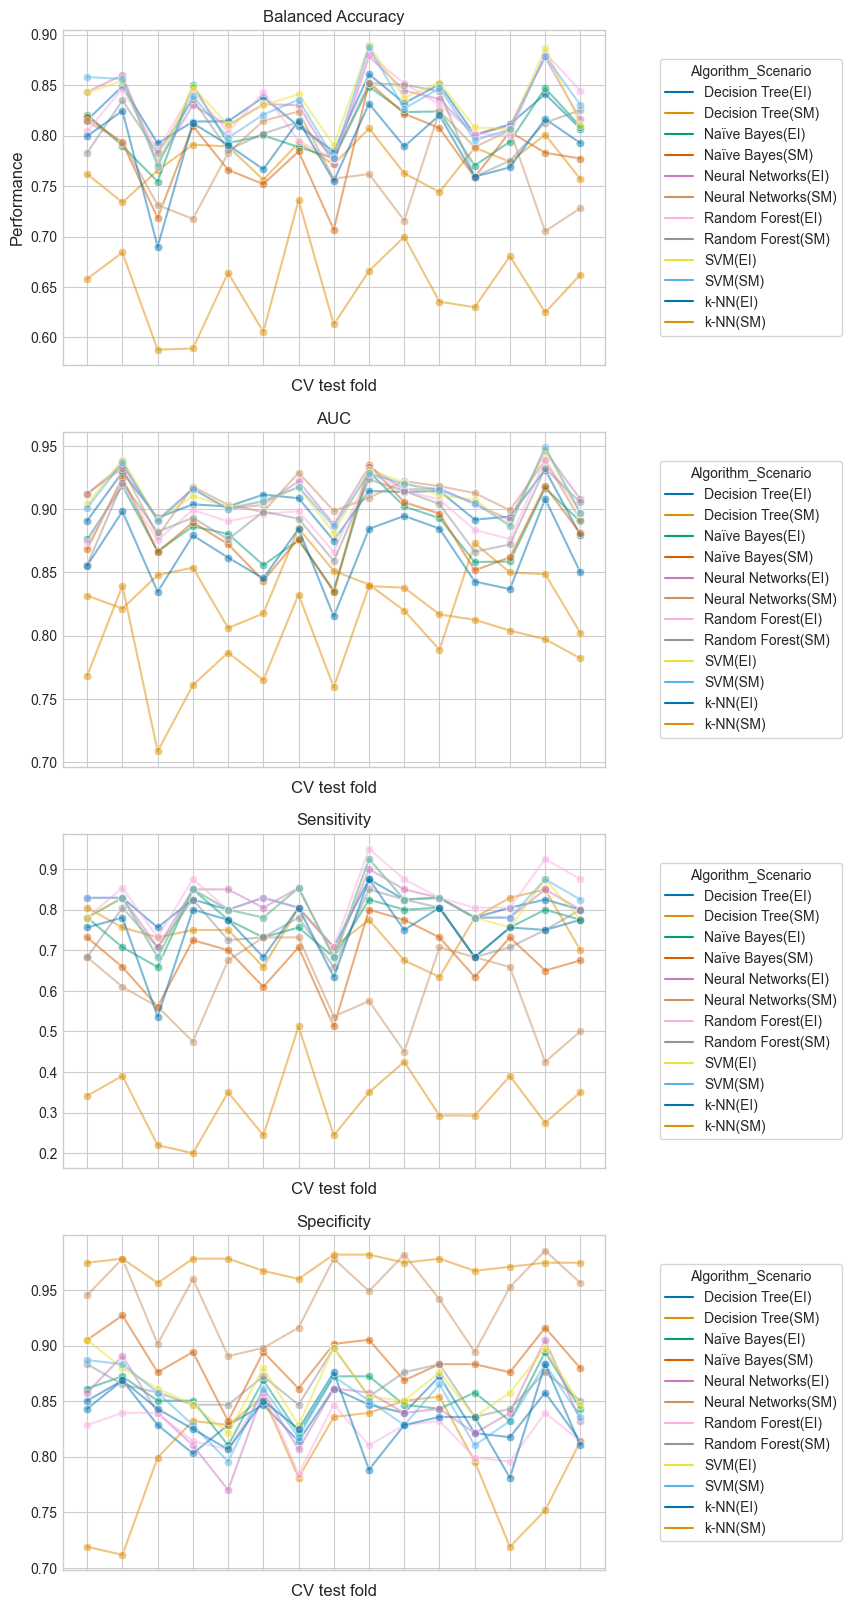

In [147]:
results_df = df_temp



# plot 30 examples of dependency between cv fold and AUC scores
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4,1,
    figsize=(7,20), 
#     sharex=False, 
#     sharey=True
)

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")
g = sns.lineplot(
    ax=ax1,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax1.set_xlabel("CV test fold", size=12, labelpad=10)
ax1.set_ylabel("Performance", size=12)
ax1.tick_params(bottom=True, labelbottom=False)
ax1.set_title('Balanced Accuracy')

sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_auc")
g = sns.lineplot(
    ax=ax2,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax2.set_xlabel("CV test fold", size=12, labelpad=10)
ax2.tick_params(bottom=True, labelbottom=False)
ax2.set_title('AUC')

sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_sensitivity")
g = sns.lineplot(
    ax=ax3,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax3.set_xlabel("CV test fold", size=12, labelpad=10)
ax3.tick_params(bottom=True, labelbottom=False)
ax3.set_title('Sensitivity')

sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_specificity")
g = sns.lineplot(
    ax=ax4,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax4.set_xlabel("CV test fold", size=12, labelpad=10)
ax4.tick_params(bottom=True, labelbottom=False)
ax4.set_title('Specificity')

sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


plt.show()

# # print correlation of Bal Acc scores across folds
# print(f"Correlation of models:")

# df_corr = pd.DataFrame(model_scores.transpose().corr())
# # display(df_corr)
# sns.heatmap(data=df_corr)

# Implement Bonferroni correction

In [166]:
from itertools import combinations
from math import factorial





# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")


n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    
    n = differences.shape[0]  # number of test sets
    df = n - 1
    
    # 5-fold: qty of rows by train and test sets 
    n_train = 1258
    n_test = 315

    t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)

pairwise_comp_df.loc[(pairwise_comp_df.p_val < 0.05)]

,model_1,model_2,t_stat,p_val
10,Decision Tree(EI),k-NN(SM),7.048,0.000
20,Decision Tree(SM),k-NN(SM),4.664,0.012
29,Naïve Bayes(EI),k-NN(SM),5.490,0.003
37,Naïve Bayes(SM),k-NN(SM),5.718,0.002
44,Neural Networks(EI),k-NN(SM),7.330,0.000
50,Neural Networks(SM),k-NN(SM),4.414,0.019
55,Random Forest(EI),k-NN(SM),5.944,0.001
59,Random Forest(SM),k-NN(SM),6.264,0.001
61,SVM(EI),k-NN(EI),4.150,0.032
62,SVM(EI),k-NN(SM),6.954,0.000


In [171]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

NameError: name 'rope_interval' is not defined

In [165]:
# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X, y, X_valid_all, y_valid_all = utils.get_train_and_validation_data(
    scaled=True,
    use_diagnosis_delay=True,
)


cv = grid.cv

n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])

print(n_train, n_test, df, n_comparisons, n)

1258 315 14 66.0 15


---
---
# TESTING BEFORE HERE
---
---



In [41]:
df_cv_results = None

for algo, scen, balanced_classifier, grid in serialized_gridsearch_objects:
   
    # do not process RadiusNN and Complement-NB
    if algo in ['RadiusNeighbors', 'ComplementNB']:
        continue

    try:    
        clf = grid.cv_results_['param_estimator']
        print(type(clf), clf)
    except:
#         print(grid.cv_results_['estimator'])
        pass

    df_aux = pd.DataFrame(grid.cv_results_)
    df_aux.insert(0, 'Algorithm', utils.get_model_description(algo) )
    df_aux.insert(1, 'Scenario', scen.replace('_', '-') )
    
#     if balanced_classifier == 'Balanced Random Forest'
#         df_aux.insert(1, 'Scenario', scen.replace('_', '-') )
#         'BalancedRandomForestClassifier'

    # acumulate the performances in a dataFrame
    if df_cv_results is None:
        df_cv_results = df_aux
    else:
        df_cv_results = pd.concat([df_cv_results, df_aux], ignore_index=True)


        
        
# results_df = pd.DataFrame(search.cv_results_)
df_cv_results = df_cv_results.sort_values(
#     by=["rank_test_score"],
    by=['Algorithm', 'Scenario', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy'],
    ascending=[True, True, False, True],
).copy()


df_cv_results['Algorithm_Scenario'] = df_cv_results.Algorithm.apply(lambda x: utils.get_model_description(x)) + \
                        ' ' + df_cv_results.Scenario.apply(lambda x: '(SM)' if x == 'Single-Model' else '(EI)')

df_cv_results['params_str'] = df_cv_results['params'].astype(str).str.replace(' ', '')

df_cv_results = df_cv_results.round(2)

# df_temp = df_temp.groupby(by=['Algorithm', 'Scenario']).first()
df_cv_results[[
    'Algorithm',
    'Scenario',
#     'Algorithm_Scenario',
#     "mean_test_balanced_accuracy", 
#     "std_test_balanced_accuracy",
    #
    "param_estimator",
#     "params",
    "params_str",
]].groupby(by=[
    'Algorithm',
    'Scenario',
]).first()
        
      

<class 'numpy.ma.core.MaskedArray'> [GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() GaussianNB() GaussianNB()
 GaussianNB() GaussianNB() GaussianNB() 

param_estimator  \
Algorithm       Scenario                                                                                                                                                                                                 
Decision Tree   Ensemble-Imbalance                                                          DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=4, random_state=42)   
                Single-Model                                                                                                                                                                                      None   
Naïve Bayes     Ensemble-Imbalance                                                                                                                                                                        GaussianNB()   
                Single-Model                                                                                                                                                                                      None   
Neural Networks Ensemble-Imbalance  MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30,\n              learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000,\n              random_state=42)   
                Single-Model                                                                                                                                                                                      None   
Random Forest   Ensemble-Imbalance                                                                                                                                                                                None   
                Single-Model                                                                                                                                                                                      None   
SVM             Ensemble-Imbalance                                                                                             SVC(C=3, class_weight='balanced', gamma='auto', probability=True,\n    random_state=42)   
                Single-Model                                                                                                                                                                                      None   
k-NN            Ensemble-Imbalance                                                                                                        KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')   
                Single-Model                                                                                                                                                                                      None   

                                                                                                                                                                                                     params_str  
Algorithm       Scenario                                                                                                                                                                                         
Decision Tree   Ensemble-Imbalance                                                                  {'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'majority','warm_start':False}  
                Single-Model                                                                                                  {'class_weight':'balanced','criterion':'entropy','max_depth':5,'random_state':42}  
Naïve Bayes     Ensemble-Imbalance                                                                       {'n_estimators':11,'random_state':42,'replacement':False,'sampling_strategy':'all','warm_start':False}  
                Single-Model                                                                    

# Filter cv_results_ keeping only the best performance for each algorithm and scenario

In [46]:
df_cv_results_of_best = None

for idx, row in df_best.iterrows():
    
#     if row.Scenario == 'Single-Model':
#         params = row.Hyperparams

#         df_aux = df_cv_results.loc[(
#              (df_cv_results.Algorithm == row.Algorithm)
#             &(df_cv_results.Scenario  == row.Scenario)
#             &(df_cv_results.params_str== params)
#         )].copy()
        
    if str(row.Model_Class) == 'BalancedRandomForestClassifier':
        params = row.Hyperparams
        print(params)

        print(row.Algorithm, row.Scenario)
        
        df_aux = df_cv_results.loc[(
             (df_cv_results.Algorithm  == row.Algorithm)
            &(df_cv_results.Scenario   == row.Scenario)
            &(df_cv_results.params_str == str(params))
        )].copy()


#     else:
#         print(row.Model_Class)
        
        
#         df_aux = df_cv_results.loc[(
#              (df_cv_results.Algorithm  == row.Algorithm)
#             &(df_cv_results.Scenario   == row.Scenario)
#             &(df_cv_results.Model_Class != 'BalancedBaggingClassifier')
# #             &(df_cv_results.param_estimator.str.contains(params)  )
#         )].copy()
        
#         df_aux = df_aux[df_aux.param_estimator.str.contains(params)]
        
#                     df[df['ids'].str.contains("ball")]

        
        
#     print(dict_params)
#     for idx, row2 in df_aux.iterrows():
#         print(row2.params_str)


#     display(df_aux[['Algorithm', 'Scenario', 'params']])
# #         display(df_aux[['params']])


    # acumulate the performances in a dataFrame
    if df_aux.shape[0] > 0:
        if df_cv_results_of_best is None:
            df_cv_results_of_best = df_aux
        else:
            df_cv_results_of_best = pd.concat([df_cv_results_of_best, df_aux], ignore_index=True)

#     print()

#     break

        
df_cv_results_of_best[[
    'Algorithm',
    'Scenario',
#     'Algorithm_Scenario',
#     "mean_test_balanced_accuracy", 
#     "std_test_balanced_accuracy",
    #
    "param_estimator",
#     "params",
    "params_str",
]]
# .groupby(by=[
#     'Algorithm',
#     'Scenario',
# ]).first()

{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}
Random Forest Ensemble-Imbalance


,Algorithm,Scenario,param_estimator,params_str
0,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
1,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
2,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
3,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
4,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
5,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
6,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
7,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
8,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
9,Random Forest,Ensemble-Imbalance,NaN,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"


In [79]:
fil = "{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"
df_cv_results.loc[(
     (df_cv_results.Algorithm  == 'Random Forest')
    &(df_cv_results.Scenario   == 'Ensemble-Imbalance')
    &(df_cv_results.params_str == fil)
#         (df_cv_results.params_str == fil)
)]



,Algorithm,Scenario,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_random_state,...,param_learning_rate_init,param_max_iter,param_solver,param_n_neighbors,param_C,param_gamma,param_kernel,param_probability,Algorithm_Scenario,params_str
2026,Random Forest,Ensemble-Imbalance,0.03,0.0,0.01,0.0,NaN,entropy,7,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Random Forest (EI),"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}"


In [45]:
df_cv_results_of_best = None

for idx, row in df_best.iterrows():
    
    dict_params = "{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}"
    
#     print(type(eval(row.Hyperparams)))
    
    if row.Hyperparams == dict_params:
    
        print(row.Algorithm, row.Scenario, row.Hyperparams)

        if row.Scenario == 'Single-Model':
            params = row.Hyperparams
#         else:
#             params = row.Estimator_Hyperparams

        df_aux = df_cv_results.loc[(
             (df_cv_results.Algorithm == row.Algorithm)
            &(df_cv_results.Scenario  == row.Scenario)
            &(df_cv_results.params_str== params)
        )].copy()

        
        print(dict_params)
        for idx, row2 in df_aux.iterrows():
            print(row2.params_str)
            
        
        display(df_aux[['Algorithm', 'Scenario', 'params']])
#         display(df_aux[['params']])
    

        # acumulate the performances in a dataFrame
        if df_cv_results_of_best is None:
            df_cv_results_of_best = df_aux
        else:
            df_cv_results_of_best = pd.concat([df_cv_results_of_best, df_aux], ignore_index=True)

        print()

        break

        
df_aux.info()        
        
# df_cv_results_of_best

SVM Single-Model {'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}
{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}
{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}


,Algorithm,Scenario,params
8235,SVM,Single-Model,"{'C': 0.3, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True, 'random_state': 42}"



<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 8235 to 8235
Columns: 282 entries, Algorithm to params_str
dtypes: float64(242), int32(7), object(33)
memory usage: 2.2+ KB


---
---
---
---
---
---

In [2]:
df_temp = df_cv_results.sort_values(
    by=['Algorithm', 'Scenario', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy'],
    ascending=[True, True, False, True],
).copy()


df_temp['Algorithm_Scenario'] = df_temp.Algorithm.apply(lambda x: utils.get_model_description(x)) + \
                        ' ' + df_temp.Scenario.apply(lambda x: '(SM)' if x == 'Single_Model' else '(EI)')

df_temp = df_temp.round(2)

# df_temp = df_temp.groupby(by=['Algorithm', 'Scenario']).first()
df_temp[[
    'Algorithm',
    'Scenario',
    'Algorithm_Scenario', 
    "params", 
    "mean_test_balanced_accuracy", 
    "std_test_balanced_accuracy"
]]



NameError: name 'df_cv_results' is not defined

We can see that the estimator using the `'rbf'` kernel performed best,
closely followed by `'linear'`. Both estimators with a `'poly'` kernel
performed worse, with the one using a two-degree polynomial achieving a much
lower performance than all other models.

Usually, the analysis just ends here, but half the story is missing. The
output of :class:`~sklearn.model_selection.GridSearchCV` does not provide
information on the certainty of the differences between the models.
We don't know if these are **statistically** significant.
To evaluate this, we need to conduct a statistical test.
Specifically, to contrast the performance of two models we should
statistically compare their AUC scores. There are 100 samples (AUC
scores) for each model as we repreated 10 times a 10-fold cross-validation.

However, the scores of the models are not independent: all models are
evaluated on the **same** 100 partitions, increasing the correlation
between the performance of the models.
Since some partitions of the data can make the distinction of the classes
particularly easy or hard to find for all models, the models scores will
co-vary.

Let's inspect this partition effect by plotting the performance of all models
in each fold, and calculating the correlation between models across folds:



KeyboardInterrupt: 

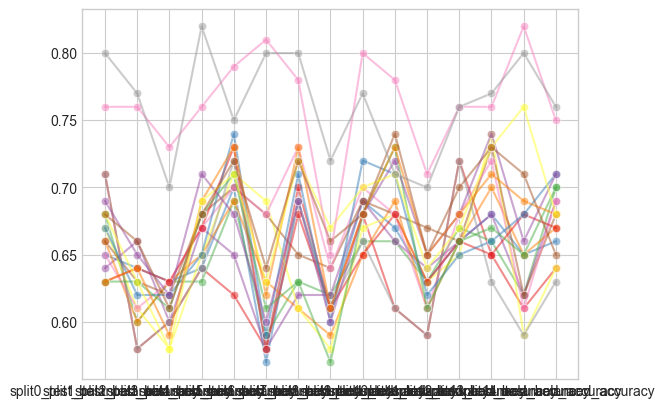

In [32]:
results_df = df_temp

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model Bal.Acc.", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:")

df_corr = pd.DataFrame(model_scores.transpose().corr())
# display(df_corr)
sns.heatmap(data=df_corr)

We can observe that the performance of the models highly depends on the fold.

As a consequence, if we assume independence between samples we will be
underestimating the variance computed in our statistical tests, increasing
the number of false positive errors (i.e. detecting a significant difference
between models when such does not exist) [1]_.

Several variance-corrected statistical tests have been developed for these
cases. In this example we will show how to implement one of them (the so
called Nadeau and Bengio's corrected t-test) under two different statistical
frameworks: frequentist and Bayesian.



## Comparing two models: frequentist approach

We can start by asking: "Is the first model significantly better than the
second model (when ranked by `mean_test_score`)?"

To answer this question using a frequentist approach we could
run a paired t-test and compute the p-value. This is also known as
Diebold-Mariano test in the forecast literature [5]_.
Many variants of such a t-test have been developed to account for the
'non-independence of samples problem'
described in the previous section. We will use the one proven to obtain the
highest replicability scores (which rate how similar the performance of a
model is when evaluating it on different random partitions of the same
dataset) while maintaining a low rate of false positives and false negatives:
the Nadeau and Bengio's corrected t-test [2]_ that uses a 10 times repeated
10-fold cross validation [3]_.

This corrected paired t-test is computed as:

\begin{align}t=\frac{\frac{1}{k \cdot r}\sum_{i=1}^{k}\sum_{j=1}^{r}x_{ij}}
   {\sqrt{(\frac{1}{k \cdot r}+\frac{n_{test}}{n_{train}})\hat{\sigma}^2}}\end{align}

where $k$ is the number of folds,
$r$ the number of repetitions in the cross-validation,
$x$ is the difference in performance of the models,
$n_{test}$ is the number of samples used for testing,
$n_{train}$ is the number of samples used for training,
and $\hat{\sigma}^2$ represents the variance of the observed
differences.

Let's implement a corrected right-tailed paired t-test to evaluate if the
performance of the first model is significantly better than that of the
second model. Our null hypothesis is that the second model performs at least
as good as the first model.



In [123]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [124]:
results_df[["params", "mean_test_score", "std_test_score"]]

,params,mean_test_score,std_test_score
estimator,,,
ComplementNB(),"{'alpha': 0.1, 'force_alpha': False, 'norm': F...",0.884144,0.022308
DecisionTreeClassifier(),"{'class_weight': 'balanced', 'criterion': 'ent...",0.846641,0.027702
GaussianNB(),{},0.883623,0.023249
KNeighborsClassifier(),"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.814900,0.020483
MLPClassifier(),"{'activation': 'relu', 'alpha': 0.3, 'hidden_l...",0.917124,0.015848
RadiusNeighborsClassifier(),"{'leaf_size': 50, 'metric': 'manhattan', 'outl...",0.584726,0.019319
RandomForestClassifier(),"{'class_weight': 'balanced', 'criterion': 'gin...",0.884170,0.020369
SVC(),"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.913239,0.016617


In [130]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])

t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\nCorrected p-value: {p_val:.3f}")

Corrected t-value: 1.858
Corrected p-value: 0.042


We can compare the corrected t- and p-values with the uncorrected ones:



In [131]:
t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(
    f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
    f"Uncorrected p-value: {p_val_uncorrected:.3f}"
)

Uncorrected t-value: 4.050
Uncorrected p-value: 0.001


Using the conventional significance alpha level at `p=0.05`, we observe that
the uncorrected t-test concludes that the first model is significantly better
than the second.

With the corrected approach, in contrast, we fail to detect this difference.

In the latter case, however, the frequentist approach does not let us
conclude that the first and second model have an equivalent performance. If
we wanted to make this assertion we need to use a Bayesian approach.



## Comparing two models: Bayesian approach
We can use Bayesian estimation to calculate the probability that the first
model is better than the second. Bayesian estimation will output a
distribution followed by the mean $\mu$ of the differences in the
performance of two models.

To obtain the posterior distribution we need to define a prior that models
our beliefs of how the mean is distributed before looking at the data,
and multiply it by a likelihood function that computes how likely our
observed differences are, given the values that the mean of differences
could take.

Bayesian estimation can be carried out in many forms to answer our question,
but in this example we will implement the approach suggested by Benavoli and
colleagues [4]_.

One way of defining our posterior using a closed-form expression is to select
a prior conjugate to the likelihood function. Benavoli and colleagues [4]_
show that when comparing the performance of two classifiers we can model the
prior as a Normal-Gamma distribution (with both mean and variance unknown)
conjugate to a normal likelihood, to thus express the posterior as a normal
distribution.
Marginalizing out the variance from this normal posterior, we can define the
posterior of the mean parameter as a Student's t-distribution. Specifically:

\begin{align}St(\mu;n-1,\overline{x},(\frac{1}{n}+\frac{n_{test}}{n_{train}})
   \hat{\sigma}^2)\end{align}

where $n$ is the total number of samples,
$\overline{x}$ represents the mean difference in the scores,
$n_{test}$ is the number of samples used for testing,
$n_{train}$ is the number of samples used for training,
and $\hat{\sigma}^2$ represents the variance of the observed
differences.

Notice that we are using Nadeau and Bengio's corrected variance in our
Bayesian approach as well.

Let's compute and plot the posterior:



In [132]:
# initialize random variable
t_post = t(
    df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
)
t_post

Let's plot the posterior distribution:



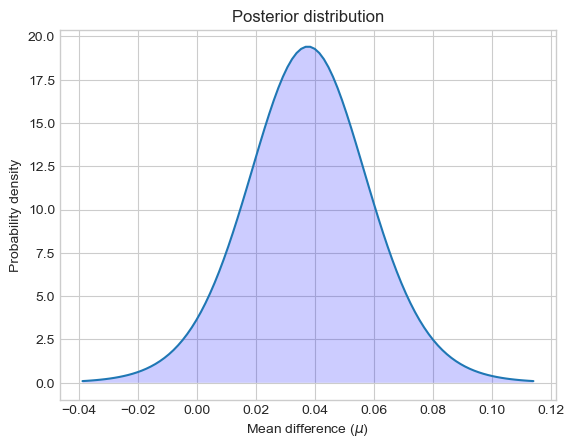

In [133]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
# plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

We can calculate the probability that the first model is better than the
second by computing the area under the curve of the posterior distribution
from zero to infinity. And also the reverse: we can calculate the probability
that the second model is better than the first by computing the area under
the curve from minus infinity to zero.



In [134]:
better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_scores.index[0]} being more accurate than "
    f"{model_scores.index[1]}: {better_prob:.3f}"
)
print(
    f"Probability of {model_scores.index[1]} being more accurate than "
    f"{model_scores.index[0]}: {1 - better_prob:.3f}"
)

Probability of ComplementNB() being more accurate than DecisionTreeClassifier(): 0.958
Probability of DecisionTreeClassifier() being more accurate than ComplementNB(): 0.042


In contrast with the frequentist approach, we can compute the probability
that one model is better than the other.

Note that we obtained similar results as those in the frequentist approach.
Given our choice of priors, we are essentially performing the same
computations, but we are allowed to make different assertions.



### Region of Practical Equivalence
Sometimes we are interested in determining the probabilities that our models
have an equivalent performance, where "equivalent" is defined in a practical
way. A naive approach [4]_ would be to define estimators as practically
equivalent when they differ by less than 1% in their accuracy. But we could
also define this practical equivalence taking into account the problem we are
trying to solve. For example, a difference of 5% in accuracy would mean an
increase of $1000 in sales, and we consider any quantity above that as
relevant for our business.

In this example we are going to define the
Region of Practical Equivalence (ROPE) to be $[-0.01, 0.01]$. That is,
we will consider two models as practically equivalent if they differ by less
than 1% in their performance.

To compute the probabilities of the classifiers being practically equivalent,
we calculate the area under the curve of the posterior over the ROPE
interval:



In [136]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(
    f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
    f"\n being practically equivalent: {rope_prob:.3f}"
)

Probability of ComplementNB() and DecisionTreeClassifier() 
 being practically equivalent: 0.080


We can plot how the posterior is distributed over the ROPE interval:



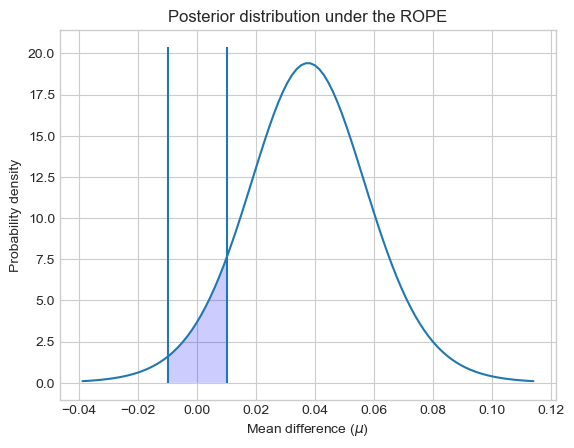

In [137]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
# plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

As suggested in [4]_, we can further interpret these probabilities using the
same criteria as the frequentist approach: is the probability of falling
inside the ROPE bigger than 95% (alpha value of 5%)?  In that case we can
conclude that both models are practically equivalent.



The Bayesian estimation approach also allows us to compute how uncertain we
are about our estimation of the difference. This can be calculated using
credible intervals. For a given probability, they show the range of values
that the estimated quantity, in our case the mean difference in
performance, can take.
For example, a 50% credible interval [x, y] tells us that there is a 50%
probability that the true (mean) difference of performance between models is
between x and y.

Let's determine the credible intervals of our data using 50%, 75% and 95%:



In [138]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,0.023527,0.051479
0.75,0.013279,0.061727
0.95,-0.005787,0.080794


As shown in the table, there is a 50% probability that the true mean
difference between models will be between 0.000977 and 0.019023, 70%
probability that it will be between -0.005422 and 0.025422, and 95%
probability that it will be between -0.016445	and 0.036445.



## Pairwise comparison of all models: frequentist approach

We could also be interested in comparing the performance of all our models
evaluated with :class:`~sklearn.model_selection.GridSearchCV`. In this case
we would be running our statistical test multiple times, which leads us to
the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

There are many possible ways to tackle this problem, but a standard approach
is to apply a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction). Bonferroni can be
computed by multiplying the p-value by the number of comparisons we are
testing.

Let's compare the performance of the models using the corrected t-test:



In [140]:
from itertools import combinations
from math import factorial

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)

pairwise_comp_df #.loc[(pairwise_comp_df.p_val < 0.05)]

,model_1,model_2,t_stat,p_val
0,ComplementNB(),DecisionTreeClassifier(),1.858,1.000
1,ComplementNB(),GaussianNB(),0.104,1.000
2,ComplementNB(),KNeighborsClassifier(),4.766,0.004
3,ComplementNB(),MLPClassifier(),-3.692,0.034
4,ComplementNB(),RadiusNeighborsClassifier(),18.491,0.000
5,ComplementNB(),RandomForestClassifier(),-0.003,1.000
6,ComplementNB(),SVC(),-3.607,0.040
7,DecisionTreeClassifier(),GaussianNB(),-1.969,0.967
8,DecisionTreeClassifier(),KNeighborsClassifier(),1.466,1.000
9,DecisionTreeClassifier(),MLPClassifier(),-3.522,0.047


We observe that after correcting for multiple comparisons, the only model
that significantly differs from the others is `'2_poly'`.
`'rbf'`, the model ranked first by
:class:`~sklearn.model_selection.GridSearchCV`, does not significantly
differ from `'linear'` or `'3_poly'`.



## Pairwise comparison of all models: Bayesian approach

When using Bayesian estimation to compare multiple models, we don't need to
correct for multiple comparisons (for reasons why see [4]_).

We can carry out our pairwise comparisons the same way as in the first
section:



In [141]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df #.loc[(pairwise_comp_df.p_val < 0.05)]

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,ComplementNB(),DecisionTreeClassifier(),1.858,1.000,0.017,0.903,0.080
1,ComplementNB(),GaussianNB(),0.104,1.000,0.027,0.040,0.933
2,ComplementNB(),KNeighborsClassifier(),4.766,0.004,0.000,0.999,0.001
3,ComplementNB(),MLPClassifier(),-3.692,0.034,0.989,0.000,0.011
4,ComplementNB(),RadiusNeighborsClassifier(),18.491,0.000,0.000,1.000,0.000
5,ComplementNB(),RandomForestClassifier(),-0.003,1.000,0.156,0.154,0.690
6,ComplementNB(),SVC(),-3.607,0.040,0.984,0.000,0.016
7,DecisionTreeClassifier(),GaussianNB(),-1.969,0.967,0.914,0.013,0.074
8,DecisionTreeClassifier(),KNeighborsClassifier(),1.466,1.000,0.037,0.834,0.129
9,DecisionTreeClassifier(),MLPClassifier(),-3.522,0.047,0.995,0.001,0.004


Using the Bayesian approach we can compute the probability that a model
performs better, worse or practically equivalent to another.

Results show that the model ranked first by
:class:`~sklearn.model_selection.GridSearchCV` `'rbf'`, has approximately a
6.8% chance of being worse than `'linear'`, and a 1.8% chance of being worse
than `'3_poly'`.
`'rbf'` and `'linear'` have a 43% probability of being practically
equivalent, while `'rbf'` and `'3_poly'` have a 10% chance of being so.

Similarly to the conclusions obtained using the frequentist approach, all
models have a 100% probability of being better than `'2_poly'`, and none have
a practically equivalent performance with the latter.



## Take-home messages
- Small differences in performance measures might easily turn out to be
  merely by chance, but not because one model predicts systematically better
  than the other. As shown in this example, statistics can tell you how
  likely that is.
- When statistically comparing the performance of two models evaluated in
  GridSearchCV, it is necessary to correct the calculated variance which
  could be underestimated since the scores of the models are not independent
  from each other.
- A frequentist approach that uses a (variance-corrected) paired t-test can
  tell us if the performance of one model is better than another with a
  degree of certainty above chance.
- A Bayesian approach can provide the probabilities of one model being
  better, worse or practically equivalent than another. It can also tell us
  how confident we are of knowing that the true differences of our models
  fall under a certain range of values.
- If multiple models are statistically compared, a multiple comparisons
  correction is needed when using the frequentist approach.



.. topic:: References

   .. [1] Dietterich, T. G. (1998). [Approximate statistical tests for
          comparing supervised classification learning algorithms](http://web.cs.iastate.edu/~jtian/cs573/Papers/Dietterich-98.pdf).
          Neural computation, 10(7).
   .. [2] Nadeau, C., & Bengio, Y. (2000). [Inference for the generalization
          error](https://papers.nips.cc/paper/1661-inference-for-the-generalization-error.pdf).
          In Advances in neural information processing systems.
   .. [3] Bouckaert, R. R., & Frank, E. (2004). [Evaluating the replicability
          of significance tests for comparing learning algorithms](https://www.cms.waikato.ac.nz/~ml/publications/2004/bouckaert-frank.pdf).
          In Pacific-Asia Conference on Knowledge Discovery and Data Mining.
   .. [4] Benavoli, A., Corani, G., Demšar, J., & Zaffalon, M. (2017). [Time
          for a change: a tutorial for comparing multiple classifiers through
          Bayesian analysis](http://www.jmlr.org/papers/volume18/16-305/16-305.pdf).
          The Journal of Machine Learning Research, 18(1). See the Python
          library that accompanies this paper [here](https://github.com/janezd/baycomp).
   .. [5] Diebold, F.X. & Mariano R.S. (1995). [Comparing predictive accuracy](http://www.est.uc3m.es/esp/nueva_docencia/comp_col_get/lade/tecnicas_prediccion/Practicas0708/Comparing%20Predictive%20Accuracy%20(Dielbold).pdf)
          Journal of Business & economic statistics, 20(1), 134-144.

